In [1]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [ ]:
from huggingface_hub import login

login()

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

#ds = load_dataset("aliabbasi1/BRIGHTER-emotion-categories", "eng", split="train")

dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Use a pretrained Hugging Face model
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

def preprocess(example):
    # Tokenize text
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    # Get labels
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

encoded_dataset = dataset.map(preprocess, batched=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/185k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/371k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2768 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/232 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5534 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Map:   0%|          | 0/2768 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]

In [ ]:

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


# Train/test split
split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_data = split["train"]
eval_data = split["test"]

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    problem_type="multi_label_classification",
    pad_token_id=tokenizer.eos_token_id
)

# Freeze base model
for param in model.base_model.parameters():
    param.requires_grad = False


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Custom metrics
def compute_metrics(eval_pred):
    from sklearn.metrics import f1_score
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (probs > 0.5).astype(int)
    return {
        "f1_micro": f1_score(labels, predictions, average="micro"),
        "f1_macro": f1_score(labels, predictions, average="macro"),
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    #learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    #load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-6-c8b5c715d091>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [7]:
# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aliabbasi (aliabbasi-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.543100,0.468332,0.586297,0.438185
2,0.437900,0.423856,0.654048,0.532844
3,0.405400,0.411867,0.643262,0.516730
4,0.388700,0.393854,0.671345,0.582329
5,0.380100,0.391645,0.677766,0.591173


TrainOutput(global_step=6920, training_loss=0.43102927676515085, metrics={'train_runtime': 3160.7694, 'train_samples_per_second': 4.379, 'train_steps_per_second': 2.189, 'total_flos': 1.034379564417024e+16, 'train_loss': 0.43102927676515085, 'epoch': 5.0})

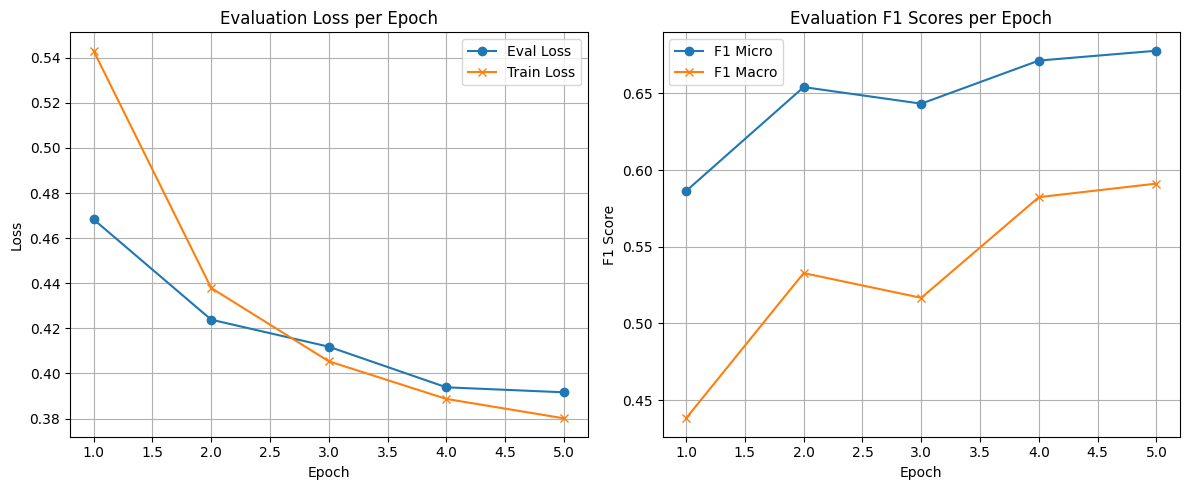

In [8]:
import matplotlib.pyplot as plt

# Extract log history (includes training and eval logs)
log_history = trainer.state.log_history

# Separate values
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_f1_micro = []
eval_f1_macro = []

for log in log_history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
        eval_f1_micro.append(log["eval_f1_micro"])
        eval_f1_macro.append(log["eval_f1_macro"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eval_epochs, eval_loss, marker='o', label="Eval Loss")
plt.plot(train_epochs, train_loss, marker='x', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss per Epoch")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_f1_micro, marker='o', label="F1 Micro")
plt.plot(eval_epochs, eval_f1_macro, marker='x', label="F1 Macro")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 Scores per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Load dataset
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
dev_dataset = dataset["test"] 
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
tokenizer.pad_token = tokenizer.eos_token

# Define the same preprocessing function used for training
def preprocess(example):
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

# Preprocess
encoded_test = dev_dataset.map(preprocess, batched=False) 

# Evaluate using Trainer
metrics = trainer.evaluate(encoded_test)
print("Validation Metrics:", metrics)

# Predict raw logits using Trainer
raw_preds = trainer.predict(encoded_test)

# Convert logits to probabilities
probs = torch.sigmoid(torch.tensor(raw_preds.predictions)).numpy()

# Apply threshold (0.5) to get binary labels
binary_preds = (probs > 0.5).astype(int)

# Prepare submission file
submission_df = pd.DataFrame(binary_preds, columns=label_names)
submission_df.insert(0, "id", dev_dataset["id"]) 

# Save to CSV
submission_df.to_csv("submission_test.csv", index=False)
print("Submission saved to submission_test.csv")

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]

Validation Metrics: {'eval_loss': 0.3916447162628174, 'eval_f1_micro': 0.6777661248033561, 'eval_f1_macro': 0.5911725589099441, 'eval_runtime': 418.9466, 'eval_samples_per_second': 13.209, 'eval_steps_per_second': 6.605, 'epoch': 5.0}
Submission saved to submission_test.csv


In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score

# Load submission file
submission_df = pd.read_csv("submission_test.csv") 

# Load gold labels
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
gold_df = pd.DataFrame(dataset["test"])

# Align dataframes by 'id'
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']
submission_df = submission_df.set_index("id").sort_index()
gold_df = gold_df.set_index("id").sort_index()
submission_df = submission_df.loc[gold_df.index]
gold_labels = gold_df[label_names].astype(int)

# Calculate metrics
binary_preds = submission_df[label_names].values
true_labels = gold_labels.values

# Macro
precision_macro = precision_score(true_labels, binary_preds, average="macro", zero_division=0)
recall_macro = recall_score(true_labels, binary_preds, average="macro", zero_division=0)
f1_macro = f1_score(true_labels, binary_preds, average="macro", zero_division=0)

# Micro
precision_micro = precision_score(true_labels, binary_preds, average="micro", zero_division=0)
recall_micro = recall_score(true_labels, binary_preds, average="micro", zero_division=0)
f1_micro = f1_score(true_labels, binary_preds, average="micro", zero_division=0)

# Print report
print("Evaluation Metrics Breakdown")
print(" Macro Average:")
print(f"   Precision: {precision_macro:.4f}")
print(f"   Recall:    {recall_macro:.4f}")
print(f"   F1 Score:  {f1_macro:.4f}")
print("\n Micro Average:")
print(f"   Precision: {precision_micro:.4f}")
print(f"   Recall:    {recall_micro:.4f}")
print(f"   F1 Score:  {f1_micro:.4f}")

Evaluation Metrics Breakdown
 Macro Average:
   Precision: 0.7542
   Recall:    0.5206
   F1 Score:  0.5912

 Micro Average:
   Precision: 0.7576
   Recall:    0.6131
   F1 Score:  0.6778
